In [26]:
from pathlib import Path
import os
import ngauge
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import pandas as pd

from brainlit.map_neurons.map_neurons import (
    Diffeomorphism_Transform,
)
from brainlit.map_neurons.diffeo_gen import diffeo_gen_ara
from brainlit.map_neurons.utils import ZerothFirstOrderNeuron
from brainlit.map_neurons.utils import replace_root
from scipy.stats import kstest

# Setup Path and Create Diffeomorphism

In [10]:
root_dir = Path(os.path.abspath(""))
data_dir = Path(os.path.join(root_dir, "data"))
sigma = 6400  # units of microns

xv, phii = diffeo_gen_ara(sigma)
ct = Diffeomorphism_Transform(xv, phii)

# Show Diffeomorphism's Profiles of Displacement and Tangent Vector Action

Computing transformed derivatives...: 100%|██████████| 7350/7350 [00:11<00:00, 648.26it/s]


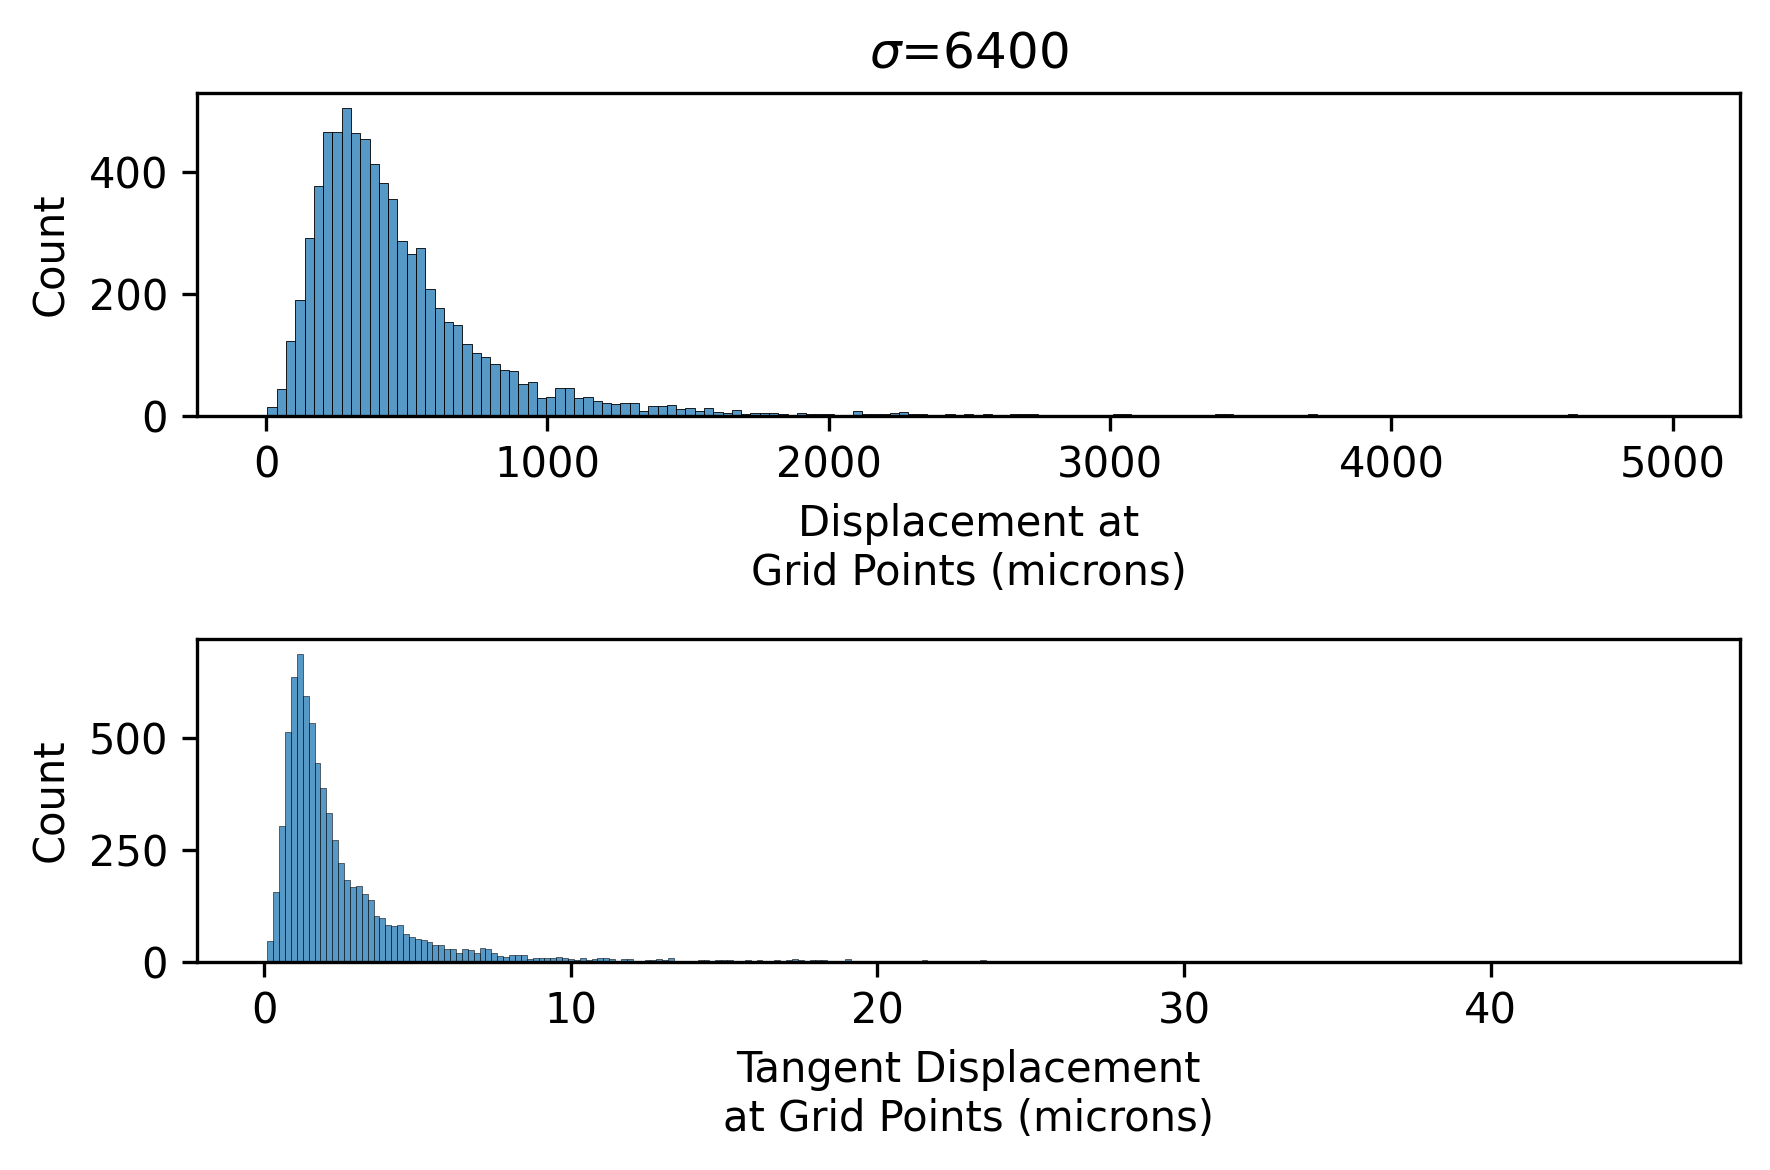

In [14]:
fig, axs = plt.subplots(2, 1, dpi=300)

og_coords = ct.og_coords
xmin = np.amin(og_coords[0])
xmax = np.amax(og_coords[0])
ymin = np.amin(og_coords[1])
ymax = np.amax(og_coords[1])
zmin = np.amin(og_coords[2])
zmax = np.amax(og_coords[2])

gap = 500
xs = np.arange(xmin + gap, xmax - gap, gap)
ys = np.arange(ymin + gap, ymax - gap, gap)
zs = np.arange(zmin + gap, zmax - gap, gap)

og_coords = np.meshgrid(xs, ys, zs, indexing="ij")
og_coords = np.array(
    [og_coords[0].flatten(), og_coords[1].flatten(), og_coords[2].flatten()]
).T
new_coords = ct.evaluate(og_coords)
new_derivs = ct.D(og_coords, np.ones(og_coords.shape), verbose=True)

position_diff = np.linalg.norm(og_coords - new_coords, axis=1)
deriv_diff = np.linalg.norm(np.ones(og_coords.shape) - new_derivs, axis=1)
data = {
    "Displacement at\nGrid Points (microns)": position_diff,
    "Tangent Displacement\nat Grid Points (microns)": deriv_diff,
}

df = pd.DataFrame(data=data)
df_filter = df[df["Displacement at\nGrid Points (microns)"] < 5000]
sns.histplot(data=df_filter, ax=axs[0], x="Displacement at\nGrid Points (microns)")
df_filter = df[df["Tangent Displacement\nat Grid Points (microns)"] < 50]
sns.histplot(
    data=df_filter, ax=axs[1], x="Tangent Displacement\nat Grid Points (microns)"
)

axs[0].set_title(rf"$\sigma$={sigma}")

plt.tight_layout()

# Plot Neuron Trace

In [15]:
def check_duplicates_center(neuron):
    assert len(neuron.branches) == 1

    stack = []
    stack += neuron.branches[0]
    coords = []

    while len(stack) > 0:
        child = stack.pop()
        stack += child.children
        coords.append([child.x, child.y, child.z])

    # look for duplicates
    dupes = []
    seen = set()
    for coord in coords:
        coord = tuple(coord)
        if coord in seen:
            dupes.append(coord)
        else:
            seen.add(coord)

    # center coordinates
    if len(dupes) > 0:
        raise ValueError(f"Duplicate nodes")
    else:
        coords = np.array(coords)
        mx = np.amax(coords, axis=0)
        mn = np.amin(coords, axis=0)
        center = np.mean(np.array([mx, mn]), axis=0)
        stack = [neuron.branches[0]]

        while len(stack) > 0:
            child = stack.pop()
            stack += child.children

            child.x -= center[0]
            child.y -= center[1]
            child.z -= center[2]

    return neuron


def plot_neuron(neuron, ax, color, label, limits=None, ax2=None, center=False):
    neuron = replace_root(neuron)
    if center:
        neuron = check_duplicates_center(neuron)

    stack = []
    stack += neuron.branches[0]

    coords = []
    first1 = True
    first2 = True
    with tqdm(total=neuron.total_child_nodes()) as pbar:
        while stack:
            node = stack.pop()
            stack += node.children

            pbar.update(1)

            coords.append([node.x, node.y, node.z])
            for child in node.children:
                if first1:
                    first1 = False
                    ax.plot(
                        [node.x, child.x],
                        [node.y, child.y],
                        [node.z, child.z],
                        c=color,
                        linewidth=1,
                        label=label,
                    )
                else:
                    ax.plot(
                        [node.x, child.x],
                        [node.y, child.y],
                        [node.z, child.z],
                        c=color,
                        linewidth=1,
                    )

                if limits is not None:
                    xmin, ymin, zmin = limits[0]
                    xmax, ymax, zmax = limits[1]

                    if (
                        node.x < xmin
                        or node.x > xmax
                        or node.y < ymin
                        or node.y > ymax
                        or node.z < zmin
                        or node.z > zmax
                    ):
                        continue
                    else:
                        for child in node.children:
                            if first2:
                                first2 = False
                                ax2.plot(
                                    [node.x, child.x],
                                    [node.y, child.y],
                                    [node.z, child.z],
                                    c=color,
                                    linewidth=1,
                                    alpha=0.5,
                                    label=label,
                                )
                            else:
                                ax2.plot(
                                    [node.x, child.x],
                                    [node.y, child.y],
                                    [node.z, child.z],
                                    c=color,
                                    linewidth=1,
                                    alpha=0.5,
                                )
                                # ax2.scatter([node.x], [node.y], [node.z], c="blue", linewidth=1, alpha=0.5)

    return ax, ax2, coords

100%|█████████▉| 759/760 [00:01<00:00, 730.51it/s]


<matplotlib.legend.Legend object at 0x1995aa2b0>

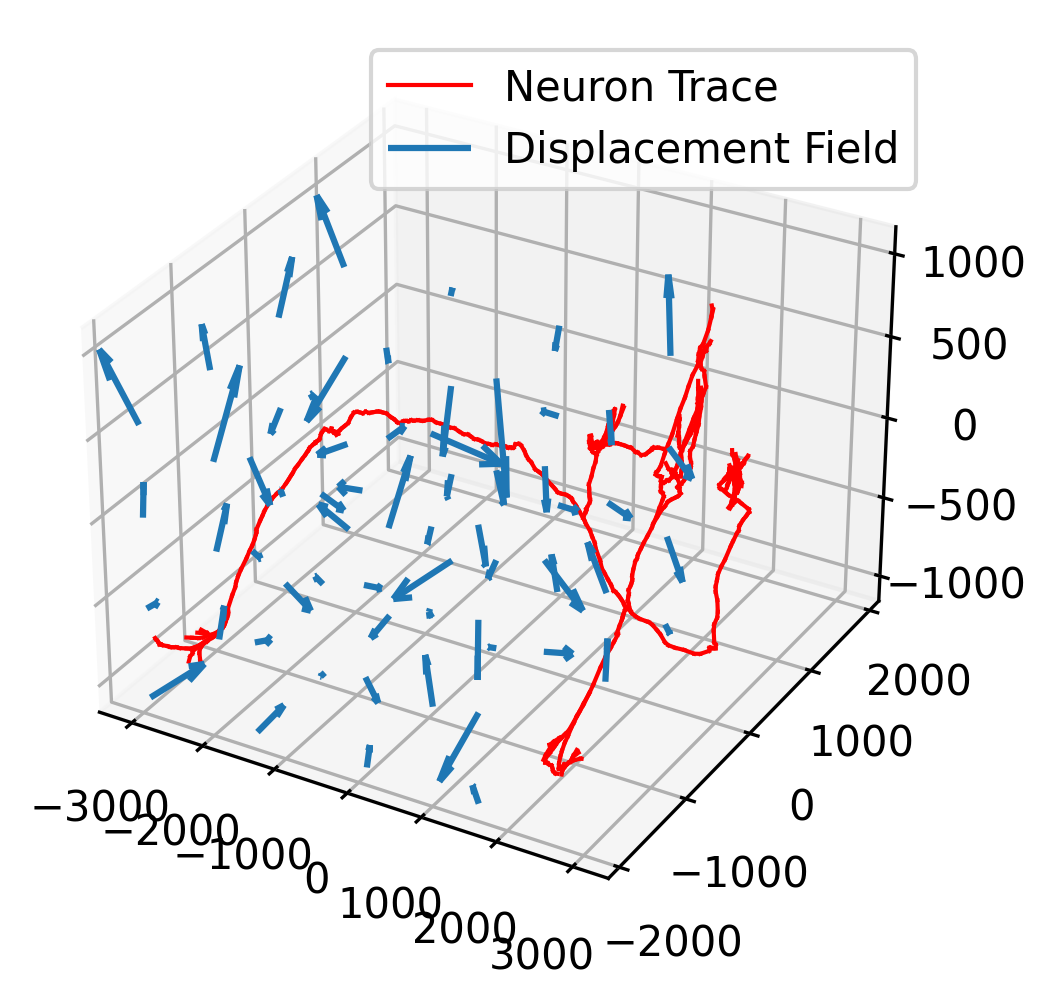

In [17]:
sample = "AA1093"

fig = plt.figure(dpi=300)
ax0 = fig.add_subplot(1, 1, 1, projection="3d")


fname = data_dir / f"{sample}.swc"
neuron = ngauge.Neuron.from_swc(fname)

ax0, _, coords = plot_neuron(
    neuron, ax=ax0, color="red", label="Neuron Trace", center=True
)


coords = np.array(coords)
mn = np.amin(coords, axis=0)
mx = np.amax(coords, axis=0)

xmin, ymin, zmin = mn[0], mn[1], mn[2]
xmax, ymax, zmax = mx[0], mx[1], mx[2]

xs = np.arange(xmin, xmax, (xmax - xmin) / 4)
ys = np.arange(ymin, ymax, (ymax - ymin) / 4)
zs = np.arange(zmin, zmax, (zmax - zmin) / 4)

og_coords = np.meshgrid(xs, ys, zs, indexing="ij")
og_coords = np.array(
    [og_coords[0].flatten(), og_coords[1].flatten(), og_coords[2].flatten()]
).T
new_coords = ct.evaluate(og_coords)

idxs2remove = []
for i, coord in enumerate(og_coords):
    if np.linalg.norm(coord - new_coords[i, :]) > 1000:
        idxs2remove.append(i)

og_coords = np.delete(og_coords, idxs2remove, axis=0)
new_coords = np.delete(new_coords, idxs2remove, axis=0)

ax0.quiver(
    og_coords[:, 0],
    og_coords[:, 1],
    og_coords[:, 2],
    new_coords[:, 0] - og_coords[:, 0],
    new_coords[:, 1] - og_coords[:, 1],
    new_coords[:, 2] - og_coords[:, 2],
    # length=2,
    label="Displacement Field",
    # alpha=0.5,
)


ax0.legend()

# Perform Mapping

In [20]:
neuron = replace_root(neuron)
neuron = check_duplicates_center(neuron)

n = ZerothFirstOrderNeuron(neuron, ct, sampling=2)

neuron_gt = n.get_gt()
neuron_0, neuron_1 = n.get_transforms()

# Plot Mapped Trace

100%|█████████▉| 14667/14668 [00:20<00:00, 723.80it/s]


<matplotlib.legend.Legend object at 0x1a0f7ff10>

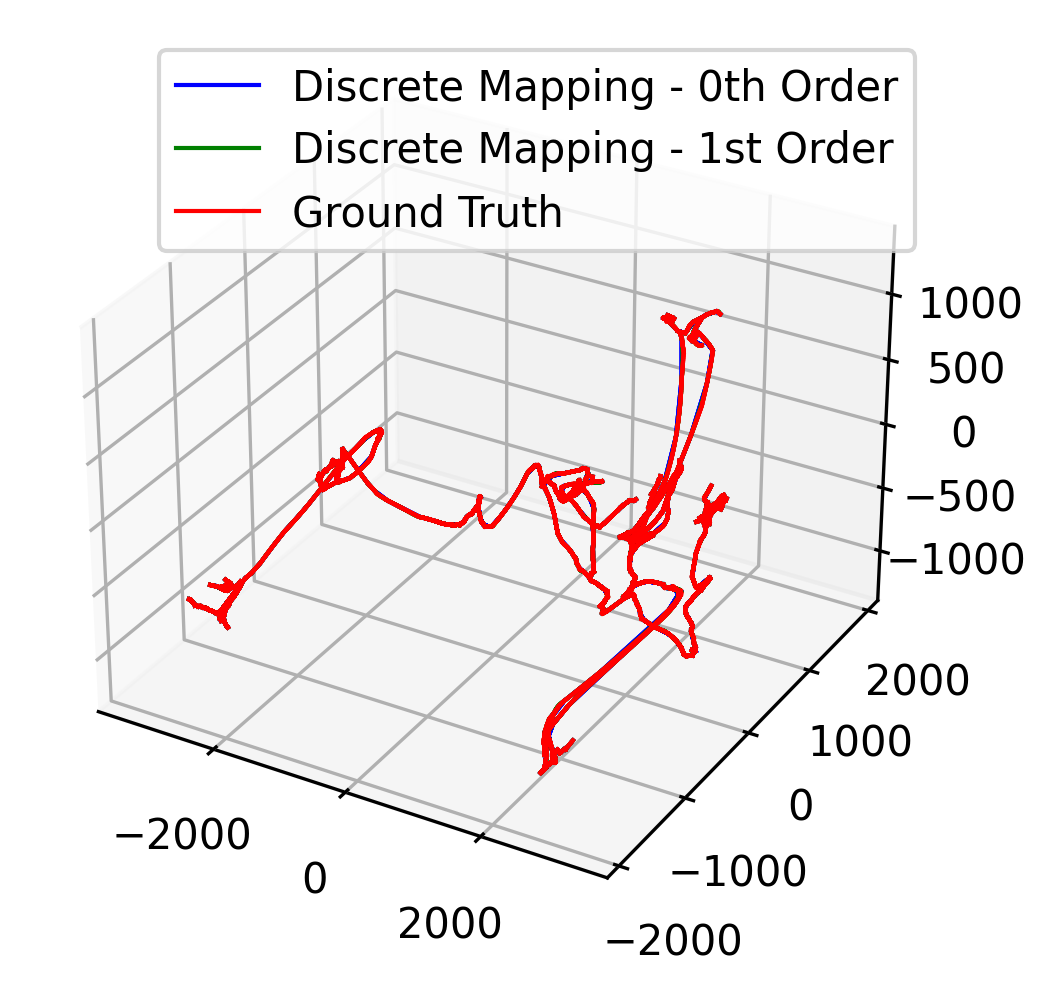

In [24]:
fig = plt.figure(dpi=300)
ax1 = fig.add_subplot(1, 1, 1, projection="3d")

ax1, ax2, _ = plot_neuron(
    neuron_0,
    ax1,
    color="blue",
    label="Discrete Mapping - 0th Order",
)


ax1, ax2, _ = plot_neuron(
    neuron_1,
    ax1,
    color="green",
    label="Discrete Mapping - 1st Order",
)

ax1, ax2, _ = plot_neuron(
    neuron_gt,
    ax1,
    color="red",
    label="Ground Truth",
)

ax1.legend()

# Compare Distributions of Morphometrics to Ground Truth

In [31]:
print(
    f"KS Stat of Path Angle Distribution Compared to Ground Truth: 0th order - {kstest(neuron_0.all_path_angles(), neuron_gt.all_path_angles()).statistic} 1st order - {kstest(neuron_1.all_path_angles(), neuron_gt.all_path_angles()).statistic}"
)
print(
    f"KS Stat of Branch Angle Distribution Compared to Ground Truth: 0th order - {kstest(neuron_0.all_branch_angles(), neuron_gt.all_branch_angles()).statistic} 1st order - {kstest(neuron_1.all_branch_angles(), neuron_gt.all_branch_angles()).statistic}"
)
print(
    f"KS Stat of Tortuosity Distribution Compared to Ground Truth: 0th order - {kstest(neuron_0.all_neurites_tortuosities(), neuron_gt.all_neurites_tortuosities()).statistic} 1st order - {kstest(neuron_1.all_neurites_tortuosities(), neuron_gt.all_neurites_tortuosities()).statistic}"
)
print(
    f"KS Stat of Segment Length Distribution Compared to Ground Truth: 0th order - {kstest(neuron_0.all_segment_lengths(), neuron_gt.all_segment_lengths()).statistic} 1st order - {kstest(neuron_1.all_segment_lengths(), neuron_gt.all_segment_lengths()).statistic}"
)

KS Stat of Path Angle Distribution Compared to Ground Truth: 0th order - 0.9487039563437927 1st order - 0.1821964529331514
KS Stat of Branch Angle Distribution Compared to Ground Truth: 0th order - 0.05660377358490566 1st order - 0.03773584905660377
KS Stat of Tortuosity Distribution Compared to Ground Truth: 0th order - 0.07142857142857142 1st order - 0.05357142857142857
KS Stat of Segment Length Distribution Compared to Ground Truth: 0th order - 0.015476920979068609 1st order - 0.006408945251244358


### The following cell may take 15-20 min to compute frechet errors

In [35]:
max_zero_error, max_first_error = n.frechet_errors()
print(
    f"Frechet error from ground truth: 0th order - {max_zero_error} 1st order - {max_first_error}"
)

Frechet error from ground truth: 0th order - 60.85654820128275 1st order - 30.25607171848977
